In [132]:
import os
import geopandas as gpd
import gdal
from pybob.GeoImg import GeoImg
import pybob.coreg_tools as ct
from pybob.plot_tools import set_pretty_fonts
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt 

In [133]:
dh = GeoImg(gdal.Open('dh_2001_2007.tif'))

/Users/elischwat/miniconda3/lib/python3.7/site-packages/pybob/GeoImg.py:345: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()  # don't forget this one!


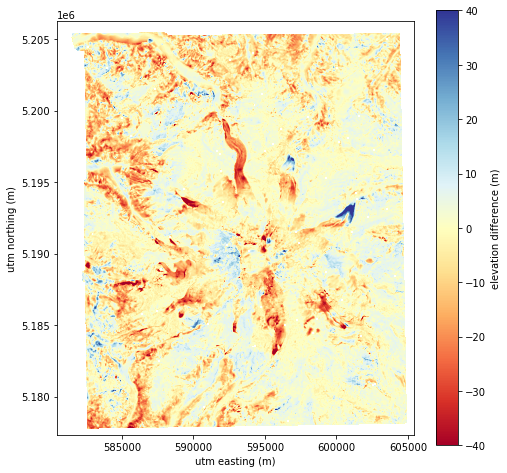

In [135]:
fig1 = dh.display(fig=plt.figure(figsize=(8,8)), cmap='RdYlBu', vmin=-40, vmax=40)
fig1.gca().set_xlabel('utm easting (m)')
fig1.gca().set_ylabel('utm northing (m)')

# add a colorbar and set the label
cb = plt.colorbar(); cb.set_label('elevation difference (m)')

## Open AOI Shapefiles

In [136]:
aoi_gdf = gpd.read_file('aoi.geojson')

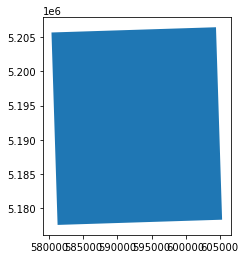

In [137]:
aoi_gdf.plot()

## Open Glacier Polygons

In [138]:
glacier_gdf = gpd.read_file('/Users/elischwat/data/rgi60/regions/rgi60_merge_CONUS.shp')
glacier_gdf = glacier_gdf.to_crs(aoi_gdf.crs)
glacier_gdf = glacier_gdf[glacier_gdf.geometry.intersects(aoi_gdf.geometry[0])]

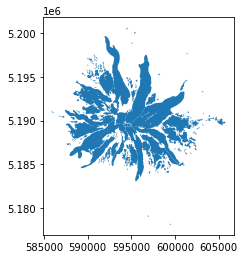

In [139]:
glacier_gdf.plot()

## Mask dh raster with glacier polygons

In [146]:
import fiona
import rasterio
import rasterio.mask

In [153]:
with rasterio.open('dh_2001_2007.tif') as src:
    out_image, out_transform = rasterio.mask.mask(src, glacier_gdf.geometry, invert=True)
    out_meta = src.meta

In [154]:
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("dh_2001_2007_glacier_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

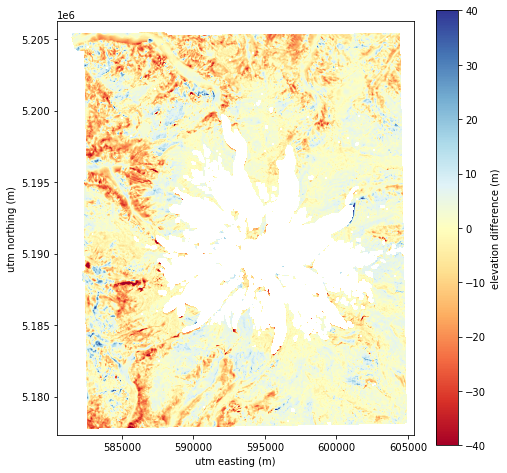

In [155]:
dh = GeoImg(gdal.Open('dh_2001_2007_glacier_masked.tif'))
fig1 = dh.display(fig=plt.figure(figsize=(8,8)), cmap='RdYlBu', vmin=-40, vmax=40)
fig1.gca().set_xlabel('utm easting (m)')
fig1.gca().set_ylabel('utm northing (m)')

# add a colorbar and set the label
cb = plt.colorbar(); cb.set_label('elevation difference (m)')

## Open Watershed

In [156]:
watershed_gdf = gpd.read_file('../data/raw/Watershed_Administrative_Units-shp/e0897e1a-7e5b-4b8e-95fe-4cd87c0220412020413-1-1r6pkvl.h57om.shp')

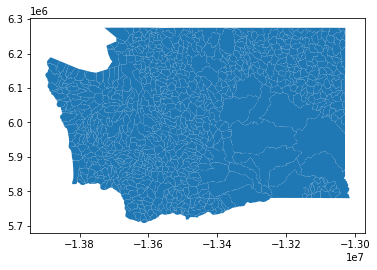

In [157]:
watershed_gdf.plot()

### Reproject watersheds shapefile into UTM 10N like everything we have

In [158]:
dh.gd.GetProjection()

'PROJCS["NAD27 / UTM zone 10N",GEOGCS["NAD27",DATUM["North_American_Datum_1927",SPHEROID["Clarke 1866",6378206.4,294.978698213898,AUTHORITY["EPSG","7008"]],AUTHORITY["EPSG","6267"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4267"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26710"]]'

In [159]:
aoi_gdf.crs

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 126°W to 120°W - by country
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [160]:
watershed_gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [161]:
watershed_gdf = watershed_gdf.to_crs(aoi_gdf.crs)

In [164]:
watershed_gdf.crs

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 126°W to 120°W - by country
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Filter watershed polygons to those intersecting our AOI

In [165]:
watershed_gdf = watershed_gdf[watershed_gdf.geometry.intersects(aoi_gdf.geometry[0])]

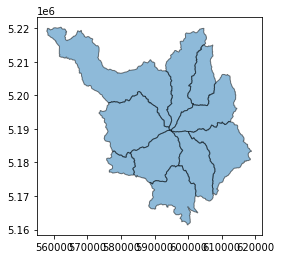

In [166]:
watershed_gdf.plot(alpha=0.5, edgecolor='k')

### Visualize Watershed Boundaries on dH Plot

In [203]:
%config InlineBackend.figure_format = 'retina'

/Users/elischwat/miniconda3/lib/python3.7/site-packages/pybob/GeoImg.py:345: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()  # don't forget this one!


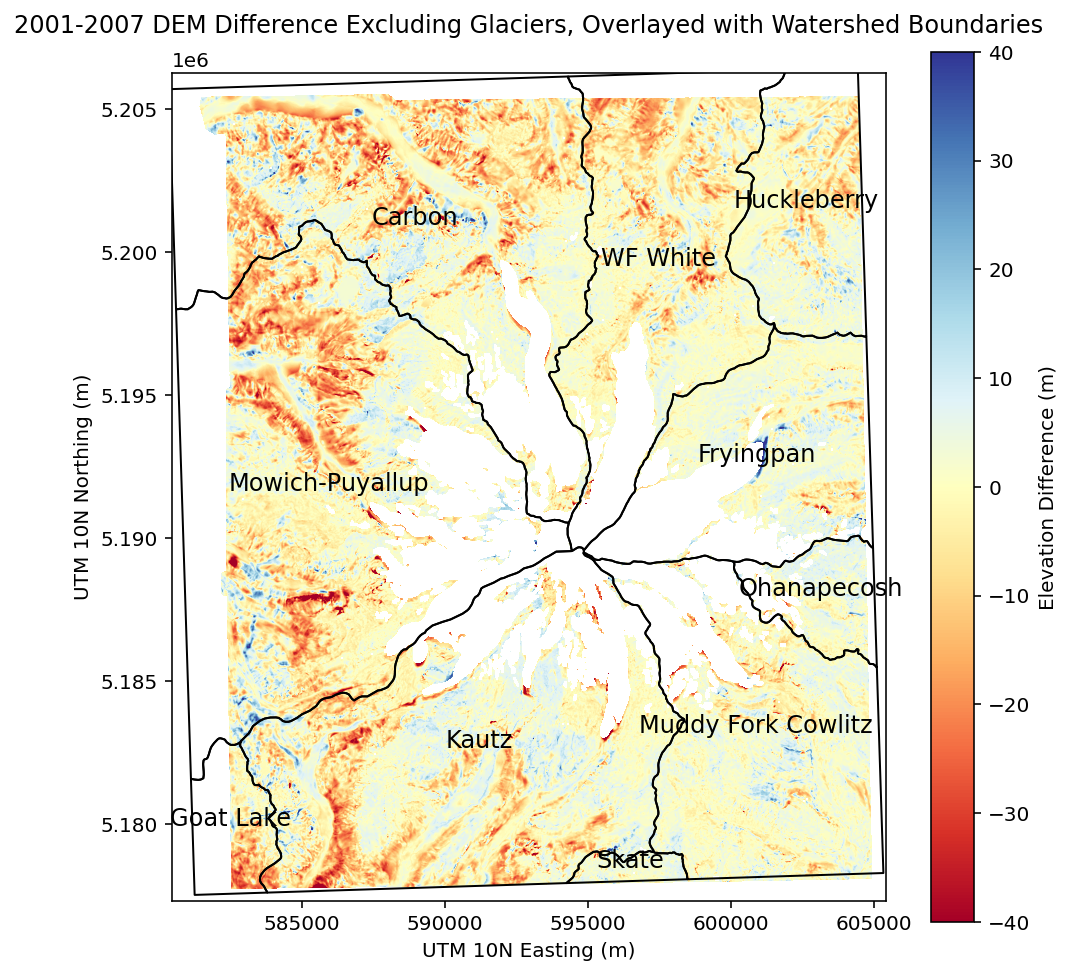

In [204]:
fig1 = dh.display(fig=plt.figure(figsize=(8,8)), cmap='RdYlBu', vmin=-40, vmax=40)
ax = fig1.gca()
ax.set_xlabel('UTM 10N Easting (m)')
ax.set_ylabel('UTM 10N Northing (m)')

# add a colorbar and set the label
cb = plt.colorbar(); cb.set_label('Elevation Difference (m)')
xlim_raster = ax.get_xlim()
ylim_raster = ax.get_ylim()
# watershed_gdf.plot(ax=ax, facecolor=None, alpha=0.1, edgecolor='k')
watershed_gdf_cropped_to_aoi = watershed_gdf.copy()
watershed_gdf_cropped_to_aoi.geometry = watershed_gdf_cropped_to_aoi.geometry.apply(lambda x: x.intersection(aoi_gdf.geometry[0]))
watershed_gdf_cropped_to_aoi.plot(
    ax=ax, 
    facecolor="None",
    edgecolor='k'
)
# Manually set these with the limits before we added the shapefile
ax.set_xlim(xlim_raster); ax.set_ylim(ylim_raster)
watershed_gdf_cropped_to_aoi.apply(lambda x: ax.annotate(s=x.WAU_LABEL_, xy=x.geometry.centroid.coords[0], ha='center', fontsize=12),axis=1);
plt.title("2001-2007 DEM Difference Excluding Glaciers, Overlayed with Watershed Boundaries", pad=20)
plt.show()

## Create Individual dH Rasters for Each Watershed

In [168]:
!mkdir individual_watersheds

mkdir: individual_watersheds: File exists


In [169]:
for i in range(0,len(watershed_gdf)):
    name = watershed_gdf[i:i+1].WAU_LABEL_.apply(lambda x: x.lower().replace(' ','-')).iloc[0]
    watershed_gdf[i:i+1].to_file(f'individual_watersheds/{name}.geojson',driver='GeoJSON')

In [170]:
!ls individual_watersheds/ 

carbon.geojson             mowich-puyallup.geojson
fryingpan.geojson          muddy-fork-cowlitz.geojson
goat-lake.geojson          ohanapecosh.geojson
huckleberry.geojson        skate.geojson
kautz.geojson              wf-white.geojson


In [191]:
!rm -rf dh_raster_cropped_by_watersheds
!mkdir dh_raster_cropped_by_watersheds/

In [192]:
!gdalwarp -of GTiff -cutline individual_watersheds/carbon.geojson -cl carbon  -crop_to_cutline dh_2001_2007_glacier_masked.tif  dh_raster_cropped_by_watersheds/carbon.tif
!gdalwarp -of GTiff -cutline individual_watersheds/fryingpan.geojson -cl fryingpan  -crop_to_cutline dh_2001_2007_glacier_masked.tif  dh_raster_cropped_by_watersheds/fryingpan.tif
!gdalwarp -of GTiff -cutline individual_watersheds/goat-lake.geojson -cl goat-lake  -crop_to_cutline dh_2001_2007_glacier_masked.tif  dh_raster_cropped_by_watersheds/goat-lake.tif
!gdalwarp -of GTiff -cutline individual_watersheds/huckleberry.geojson -cl huckleberry  -crop_to_cutline dh_2001_2007_glacier_masked.tif  dh_raster_cropped_by_watersheds/huckleberry.tif
!gdalwarp -of GTiff -cutline individual_watersheds/kautz.geojson -cl kautz  -crop_to_cutline dh_2001_2007_glacier_masked.tif  dh_raster_cropped_by_watersheds/kautz.tif
!gdalwarp -of GTiff -cutline individual_watersheds/mowich-puyallup.geojson -cl mowich-puyallup  -crop_to_cutline dh_2001_2007_glacier_masked.tif  dh_raster_cropped_by_watersheds/mowich-puyallup.tif
!gdalwarp -of GTiff -cutline individual_watersheds/muddy-fork-cowlitz.geojson -cl muddy-fork-cowlitz  -crop_to_cutline dh_2001_2007_glacier_masked.tif  dh_raster_cropped_by_watersheds/muddy-fork-cowlitz.tif
!gdalwarp -of GTiff -cutline individual_watersheds/ohanapecosh.geojson -cl ohanapecosh  -crop_to_cutline dh_2001_2007_glacier_masked.tif  dh_raster_cropped_by_watersheds/ohanapecosh.tif
!gdalwarp -of GTiff -cutline individual_watersheds/skate.geojson -cl skate  -crop_to_cutline dh_2001_2007_glacier_masked.tif  dh_raster_cropped_by_watersheds/skate.tif
!gdalwarp -of GTiff -cutline individual_watersheds/wf-white.geojson -cl wf-white  -crop_to_cutline dh_2001_2007_glacier_masked.tif  dh_raster_cropped_by_watersheds/wf-white.tif

Creating output file that is 3745P x 2973L.
Processing dh_2001_2007_glacier_masked.tif [1/1] : 0Using internal nodata values (e.g. 0) for image dh_2001_2007_glacier_masked.tif.
Copying nodata values from source dh_2001_2007_glacier_masked.tif to destination dh_raster_cropped_by_watersheds/carbon.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1967P x 1723L.
Processing dh_2001_2007_glacier_masked.tif [1/1] : 0Using internal nodata values (e.g. 0) for image dh_2001_2007_glacier_masked.tif.
Copying nodata values from source dh_2001_2007_glacier_masked.tif to destination dh_raster_cropped_by_watersheds/fryingpan.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 855P x 726L.
Processing dh_2001_2007_glacier_masked.tif [1/1] : 0Using internal nodata values (e.g. 0) for image dh_2001_2007_glacier_masked.tif.
Copying nodata values from source dh_2001_2007_glacier_masked.tif to destination dh_raster_cropped

In [193]:
ls dh_raster_cropped_by_watersheds

carbon.tif              kautz.tif               skate.tif
fryingpan.tif           mowich-puyallup.tif     wf-white.tif
goat-lake.tif           muddy-fork-cowlitz.tif
huckleberry.tif         ohanapecosh.tif


## Calculate Net Elevation Change in each Watershed

In [194]:
raster_dict = {}
for filename in os.listdir('dh_raster_cropped_by_watersheds/'):
    raster_dict[filename.split('.')[0]] = GeoImg(gdal.Open(f'dh_raster_cropped_by_watersheds/{filename}'))

In [195]:
volume_change_dict = {}
volume_change_normalized_dict = {}
for k,v in raster_dict.items():
    volume_change = np.nansum(v.img.flatten() * abs(v.dx) * abs(v.dy))
    total_area = len(v.img.flatten()) * abs(v.dx) * abs(v.dy)
    volume_change_dict[k] = volume_change
    volume_change_normalized_dict[k] = volume_change / total_area

In [196]:
volume_change_df = pd.DataFrame({
    'watershed': list(volume_change_dict.keys()),
    'watershed2': list(volume_change_normalized_dict.keys()),
    'volume_diff_m3': list(volume_change_dict.values()),
    'volume_diff_normalized_m3': list(volume_change_normalized_dict.values())
})

volume_change_df['volume_diff_km3'] = volume_change_df['volume_diff_m3']/(1000*1000*1000)

In [197]:
volume_change_df

,watershed,watershed2,volume_diff_m3,volume_diff_normalized_m3,volume_diff_km3
0,fryingpan,fryingpan,83382208.0,0.246028,0.083382
1,skate,skate,8778459.0,0.034047,0.008778
2,huckleberry,huckleberry,13092475.0,0.085400,0.013092
3,muddy-fork-cowlitz,muddy-fork-cowlitz,62827480.0,0.228185,0.062827
4,carbon,carbon,-266118112.0,-0.239016,-0.266118
5,wf-white,wf-white,-102721280.0,-0.276829,-0.102721
6,ohanapecosh,ohanapecosh,26946456.0,0.065643,0.026946
7,mowich-puyallup,mowich-puyallup,-330494880.0,-0.803446,-0.330495
8,kautz,kautz,-134226960.0,-0.538186,-0.134227
9,goat-lake,goat-lake,-38735208.0,-0.624027,-0.038735


In [198]:
alt.Chart(volume_change_df).mark_bar().encode(
    x = alt.X('watershed:N', title='', axis=alt.Axis(labelAngle=-30, labelFontSize=14)),
    y = alt.Y(alt.repeat("row"), type='quantitative', axis=alt.Axis(labelFontSize=14))
).properties(
    width=400,
    height=300
).resolve_scale(
    x='shared'
).repeat(
    row=['volume_diff_km3', 'volume_diff_normalized_m3'],
).configure_axis(
    labelFontSize=16,
    titleFontSize=16
)

alt.RepeatChart(...)